# Function: get_gif_n_image()
#### def get_gif_n_image(link, file_name_show=False, dict_appearance=False, show_error_logs=False, only_picture_name=False)

I'd like to share my function that allows adding pictures to the code that is posted in this forum: so they can be displayed. The reason why I do it is such: If someone wants to see my code, but don't want to download all data (a folder with an `.ipnb` file and all pictures, gifs etc) he or she will just click `.ipnb` file and open it directly from the forum. But, If the project has some code that displays the image, it won't be open. It's because there are no other files: forum script read only `.ipnb` file and execute it. I don't know how it works behind the curtain, but I know one thing: this script (from forum page) allows showing the output of the code. So, all is needed to display a picture is to upload those pictures via code and that's what my function basically do.

The task seemed to be easy at the beginning. Inspired by [Elena_Kosourova](https://community.dataquest.io/u/Elena_Kosourova) [article](https://community.dataquest.io/t/hidden-treasures-of-python-rarely-used-libraries-and-how-to-use-them/550915/1) I try to implement the `Wget` library. The idea was: download any needed picture with this library and display it from the file. I don't know is it possible to display link any other way in code in circumstances mentioned above. It was a cool challenge to write it. 

Let's see how a function handles a gif. At this point don't read the code ( it will be posted in the last cell once again).

In [1]:
# The code below was written by Paweł Pedryc.
# For non-commercial use only. If you need it for anything commercial, please contact me first. 
# If you want to know more,
# or want to ask about anything please write at pawel.pedryc@gmail.com
# The discussion abot this code is happening here: 

# Download file into Jupyter Notebook:
import wget # we need to install this via console command: pip install wget

# Convert svg to png:
# https://stackoverflow.com/questions/6589358/convert-svg-to-png-in-python
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Removing files from folder:
import os

# Searching for files:
import glob 

# Display PNG:
    
from IPython.display import Image, display

# Needed for display log with the error exeption function:
# https://realpython.com/the-most-diabolical-python-antipattern/
import logging

# Adding jpeg and jpg:
# https://stackoverflow.com/questions/13137817/how-to-download-image-using-requests

import requests
import shutil

# Counter needed for distinguish between files with the same name:
from collections import Counter

# Needed for saving dictionaries
# https://realpython.com/python-json/#a-very-brief-history-of-json
import json

# Checking if file exist
# https://linuxize.com/post/python-check-if-file-exists/
import os.path



def get_gif_n_image(link, file_name_show=False, dict_appearance=False, show_error_logs=False, only_picture_name=False):
    """
    Function get_gif_n_image will take any image (jpg, jpeg, png and svg),
    or gif, from the link that opens this object in the browser. After that,
    it will be saved in the current folder, convert (if needed) to png (from svg format)
    and - finally - displayed. The function will delate svg file after conversion. 
    In that case, it will live only png version, so, there won't be any garbage 
    in folder. 
    """
    
    """Working with link string"""
    
###################### .gif, .png, .svg, .webp files process below: ################################   

    if (
        link.rfind('.gif') != -1 
        or link.rfind('.png') != -1
        or link.rfind('.svg') != -1 
        or link.rfind('.webp') != -1):  # '-1' means that 'rfind()' didn't find match: https://www.programiz.com/python-programming/methods/string/find
    
        # 'File name' search:

        file_name_start = link.rfind('/')
        file_name_type = link.rfind('.')
        file_name = link[file_name_start+1 : file_name_type]
#         # Test:
#         print('file_name:', file_name)

        # 'File type' search:
        image_type_index_start = link.rfind('.')
        if '.gif' or '.png' or '.svg' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 4]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 4]
        elif '.webp' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 5]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 5]
#         # Test:
#         print('image_type_index:', image_type_index)

        # 'File name' with "file type" string:
        file_name_and_type = file_name + image_type_index_dot        
#         # Test:
#         print('file_name_and_type:', file_name_and_type)
        
        
        """
            ###  THE DICTIONARY GENERATION MODULE ###
            
        Because we don't know is the name from a link is unique or not,
        we need to build a dictionary which will match
        the link's name and the name of a generated file in the current folder.

        An example of this situation is when we try to use get_gif_n_image on this site:
        https://media.giphy.com

        Every gif here has the same name. Two different gifs below:
        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif
        
        Every time we call our main fuction 'get_gif_n_image' 
        (let's suppose we call it twice, for those links above), 
        the names for files in current folder will be:

        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif -> file_name -> 'giphy.gif'
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif -> file_name -> 'giphy (1).gif'

        BUT, our 'file_name' + 'image_type_index_dot' object will see each link as:
        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy.gif'
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy.gif'

        Python record both, but it will rename second as: 'giphy (1).gif; in current folder. 
        The problem is: our code detects name as 'giphy.gif' in link every time. 
        We need to fix it, so the relation between 'file_name' object and links will be
        with logic:
        
        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy.gif'
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy (1).gif'
        

        We will build a dictionary that will be a separate file (json format). 
        It will store data that will archive every use of our 'get_gif_n_image' function.
        It will be open and checked every time the main function : get_gif_n_image - will be called.
        
        If the probem described above will appear, it will fix it
        """
        # check if the dictionary: 'dict_for_links' exist. If so: open it:
        # https://realpython.com/python-json/#a-very-brief-history-of-json
        try:
            a_file = open("dict_for_links.json", "r")

            dict_for_links = json.load(a_file)
            # Test:
            if dict_appearance == True:
                print("dict_for_links first appearance (try):", dict_for_links)

            # The first thing we need to do is to add 'name_counter' key to the dictionary.
            # It will count instances of same name accured in the function:
            if (file_name in dict_for_links) and (link not in dict_for_links):
                dict_for_links[file_name] += 1
                
                # dict_for_links: {'giphy': '', 'https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif': 'giphy'}
                # If the name[key] (for ex. 'giphy.gif') exist in `dict_for_links` and it has value >= 1 
                # like 'giphy (1).gif' then in link[key] we rename string value from
                # 'giphy.gif' to 'giphy (1).gif':
                dict_for_links[link] = file_name + ' (' + str(dict_for_links[file_name]) + ')'
                
            else:
    #             # If the file_name wasn't present in dict the name is without number ( value will be: 0).
    #             # For ex. if we have link with 'file_name': "giphy.gif", then first apperance is:
    #             # "giphy.gif". Next one should be written as "giphy.gif (1) in dictionary"
                dict_for_links[file_name] = 0 
                dict_for_links[link] = file_name # first link can have the same name
            
        except Exception as e:
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except Exception]: no file in current folder.' + str(e))
                print('Caught an error [in code used: except Exception]: no file in current folder.')
            
            dict_for_links = {} # there was no dict so we create one
            dict_for_links[file_name] = 0 
            dict_for_links[link] = file_name # first link can have the same name
            if dict_appearance == True:
                print('dict_for_links first appearance (with exception error):', dict_for_links)
                
        else:

            # load it back again:
            a_file = open("dict_for_links.json", "r")

            dict_for_links = json.load(a_file)
            # Test:
            if dict_appearance == True:
                print("dict_for_links first appearance (else):", dict_for_links)
#             # Test:
#             print("dict_for_links:", dict_for_links)

        # The first thing we need to do is to add 'name_counter' key to the dictionary.
        # It will count instances of same name accured in function
        if (file_name in dict_for_links) and (link not in dict_for_links):
            dict_for_links[file_name] += 1

            # dict_for_links: {'giphy': '', 'https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif': 'giphy'}
            # If the name[key] (for ex. 'giphy.gif') exist in `dict_for_links` and it has value >= 1 
            # like 'giphy (1).gif' then in link[key] we rename string value from
            # 'giphy.gif' to 'giphy (1).gif':

            dict_for_links[link] = file_name + ' (' + str(dict_for_links[file_name]) + ')'
        
        # rename 'file_name' object when there are many similar like 'giphy (1).gif':
        if link in dict_for_links:
            file_name = dict_for_links[link]
            file_name_and_type = file_name + image_type_index_dot


        # Find the file - if possible:
        try:
            """
            Link proper name of the file in current folder when
            there are many files with the same name 
            and system add (num) at the end of the file name
            """
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/
            if os.path.isfile(file_name_and_type) == False:
                wget.download(link)
                active_link_or_file_exist = True
            """
            If there is a file in current folder than we can use 'active_link_or_file_exist'. 
            It will be needed for "get_gif_n_image"'s arg: 'only_picture_name':
            """
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
        except Exception as e:
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except Exception]: no image in current folder, or active link from web (with image), or both.' + str(e))
                print('Caught an error [in code used: except Exception]: no image in current folder, or active link from web (with image), or both.')
        except OSError as ose:
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except OSError]: no image in current folder, or active link from web (with image), or both.' + str(ose))
                print('Caught an error [in code used: except OSError]: no image in current folder, or active link from web (with image), or both.')
        else:
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/
            if os.path.isfile(file_name_and_type) == False:
                wget.download(link)
                active_link_or_file_exist = True
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
          
        finally:
# #             Test:
#             print('file_name_and_type:', file_name_and_type)
#             Test:
            if dict_appearance == True:
                print('dict_for_links second appearance (in finnaly statement):', dict_for_links)
            
            """Converting svg and webp file type - if it happend"""
            if active_link_or_file_exist == True and (image_type_index == 'svg' or image_type_index == 'webp'):
#                 try:
                # https://stackoverflow.com/questions/6589358/convert-svg-to-png-in-python
                # Convert svg to png:
                drawing = svg2rlg(file_name_and_type)
                png = ".png"
                renderPM.drawToFile(drawing, file_name + png, fmt="PNG")

                # Removing svg file from folder:
                """
                We don't need two formats of the file_name. 
                So, we remove old one, 
                so there will be less garbage in folder.
                """
                os.remove(file_name_and_type)
                file_name_and_type = file_name + '.png'
#                 # Test:
#                 print('The new file name and type:', file_name_and_type)


        # Return file name:
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/        
            if file_name_show == True and os.path.isfile(file_name_and_type) == True:
                print(file_name_and_type)

            if only_picture_name == True and os.path.isfile(file_name_and_type) == True:
                print(file_name_and_type)

                
            # Display pictures from the current folder:
            # Searching for file match in current folder, more about here:
            # https://stackoverflow.com/questions/58399676/how-to-create-an-if-statement-in-python-when-working-with-files
            # We set a current directory.
            directory = '.'
            choices = glob.glob(os.path.join(directory, '{prefix}*.*'.format(prefix = file_name)))
            
            if only_picture_name == False and any(choices):
                name_proper_format_list = choices

                for string in name_proper_format_list:
                    name_proper_format = string[2:]
                # https://stackoverflow.com/questions/35145509/why-is-ipython-display-image-not-showing-in-output
                i = Image(name_proper_format)
                display(i)

            else:
                pass
#                 # Test:
#                 print('name_proper_format:', name_proper_format)
                
        # Saving dictionary in current folder: 
        # https://realpython.com/python-json/#a-very-brief-history-of-json
        with open("dict_for_links.json", "w") as write_file:
            # https://www.geeksforgeeks.org/json-dump-in-python/
            json.dump(dict_for_links, write_file)
            write_file.close()

###################### .jpeg and .jpg files process below: ################################


    elif link.rfind('.jpeg') != -1 or link.rfind('.jpg') != -1: # '-1' means that 'rfind()' didn't find match: https://www.programiz.com/python-programming/methods/string/find

        # 'File name' search:
        file_name_start = link.rfind('/')
        file_name_type = link.rfind('.')
        file_name = link[file_name_start+1 : file_name_type]
#         # Test:
#         print('file_name:', file_name)

        # 'File type' search:
        image_type_index_start = link.rfind('.')
        if link.rfind('.jpeg') != -1 and '.jpeg' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 5]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 5]
        elif link.rfind('.jpg') != -1 and '.jpg' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 4]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 4]
#         # Test:
#         print('image_type_index_dot:', image_type_index_dot)

        # 'File name' with "file type" string:
        file_name_and_type = file_name + image_type_index_dot
#         # Test:
#         print('file_name_and_type:', file_name_and_type)

        """
        This code check if a name of the file is duplicated in link.
        If it is so, function will return a name that is shorter.
        Else: It return string: file name + format
        """
        full_link_list = link.split('/')
        filtering_link_name = {}
        for name_x in full_link_list:
#         #Test:
        #     print(name_x)
            if file_name_and_type.find(name_x) != -1 and name_x.find('.') != -1:
                filtering_link_name[name_x] = len(name_x)
                """
                If we have two instances of file name,
                than we have to set shorter as file name
                """
                if len(filtering_link_name) > 1:
                    file_name_and_type = min(
                        filtering_link_name,
                        key=filtering_link_name.get)
                else:
                    pass
                          
        try:
            # Try to download file if it doesn't exist in current folder.
            # It will save time if file for download is big and not needed:
            directory = '.'
            file_path = glob.glob(os.path.join(directory, '{prefix}'.format(prefix = file_name_and_type)))
            if not any(file_path):
                r = requests.get(link,
                                 stream=True, headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64)' 
                                      'AppleWebKit/537.11 (KHTML, like Gecko)'
                                      'Chrome/23.0.1271.64 Safari/537.11',
                        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                        'Accept-Encoding': 'none',
                        'Accept-Language': 'en-US,en;q=0.8',
                        'Connection': 'keep-alive'}) # We added all user-agents for avoiding error 403

                # Open picture's file:
                if r.status_code == 200:
                    with open(str(file_name_and_type), 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
        except Exception as e:
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except Exception]: no image in current folder, or active link from web (with image), or both.' + str(e))
                print('No active link.')

        else:
            # Try to download file if it doesn't exist in current folder:
            directory = '.'
            c = glob.glob(os.path.join(directory, '{prefix}'.format(prefix = file_name_and_type)))
            if not any(c):
                r = requests.get(link,
                                 stream=True, headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64)' 
                                      'AppleWebKit/537.11 (KHTML, like Gecko)'
                                      'Chrome/23.0.1271.64 Safari/537.11',
                        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                        'Accept-Encoding': 'none',
                        'Accept-Language': 'en-US,en;q=0.8',
                        'Connection': 'keep-alive'}) # We added all user-agents for avoiding error 403

                # Open picture's file:
                if r.status_code == 200:
                    with open(str(file_name_and_type), 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
        finally:
            try:
                if only_picture_name == False:
                    a = Image(file_name_and_type)
                    display(a)
            except Exception:
                print('File not found.')

            
        # Return file name:
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/        
        if file_name_show == True and os.path.isfile(file_name_and_type) == True:
            print(file_name_and_type)

        if only_picture_name == True and os.path.isfile(file_name_and_type) == True:
            print(file_name_and_type)

    
    else:
        print('Unknown file format or file not detected.')

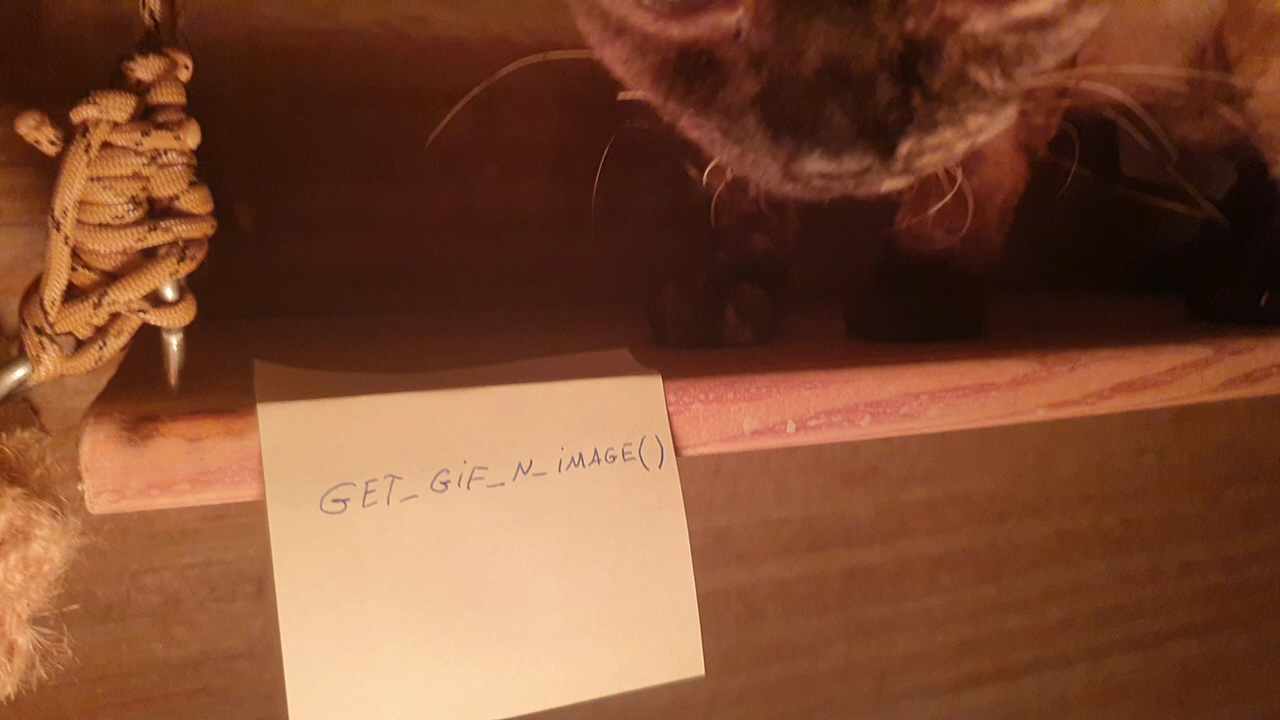

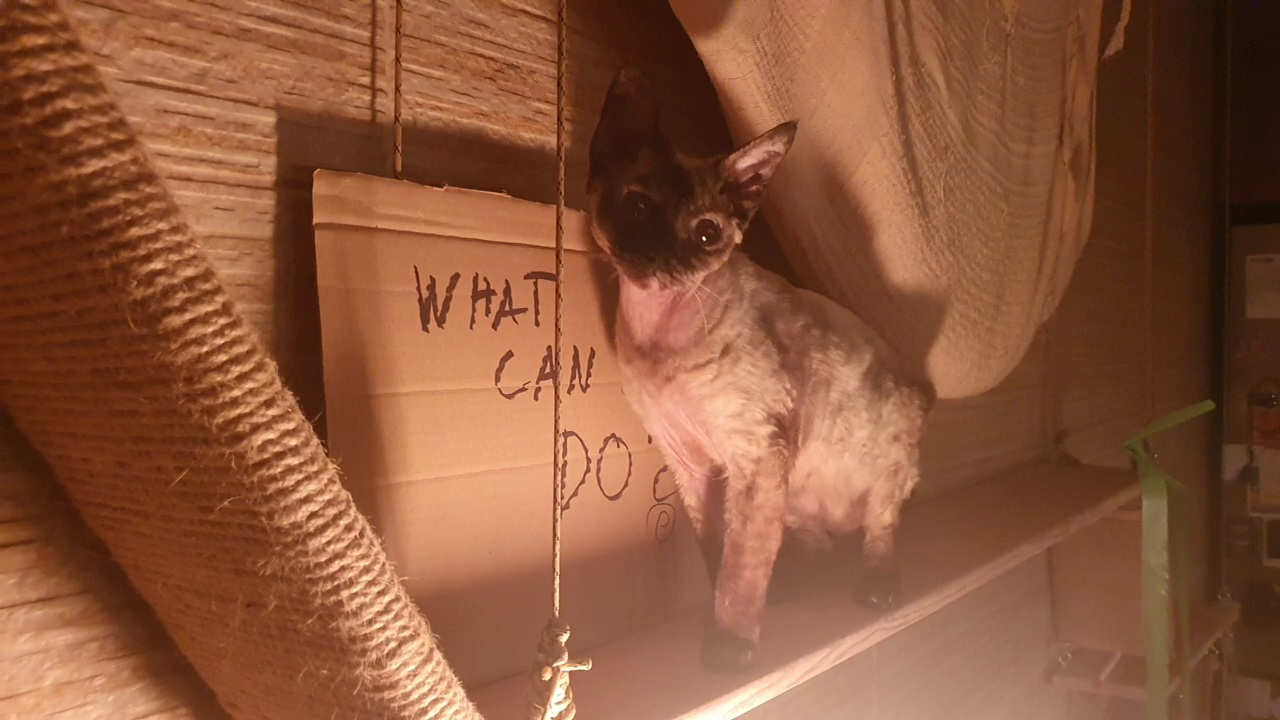

In [5]:
get_gif_n_image('https://s4.gifyu.com/images/VideoCapture_20210331-022704.jpg')
get_gif_n_image('https://s4.gifyu.com/images/VideoCapture_20210331-022732.jpg')

My approach has few reasons:
1. When we download a picture we can display it in markdown (the only way I found to display every type picture and gif in markdown is from the drive/current folder. If the markdown link isn't provided by site, this function provide a solution).
2. We have easy acces to file type and name.
3. We don't need to care so much about the file format.


But the task wasn't easy. It took me 3 weeks to finish. Below I will point out all problems I perceive. But first, let's list what my function can do. 

**Basic properties:** 
1. It can handle: `.png`, `.svg`,  `.webp`,  `.gif`, `.jpeg`, `.jpg`
2. It takes a link as input, analyze it: looks for file name and format.
3. It download the file and display it from the current folder. 

The problems that made things complex:
1. Some links have two segments with file name, where one has some additional information about how it should be displayed - and we need just the file name part ( because we need to have the same string as the file name in the current folder). So my function has to know what to choose.
2. `.svg` file is hard to open in Python. So my function needs to detect this file format and convert it to png. If I remember correctly, the same problem was with `.webp` format. 
3.  Some links have the same file name - no matter what picture from the site is chosen. So my function has to have a dictionary to know what file in the current folder is related to what picture name/link ( more about it in the documentation: in code). [This works only with `.png`, `.svg`,  `.webp`,  `.gif` ]
4. Picture has to display even when the link is broken - if the function successfully downloads it earlier. 
5. If the link is dead and we don't have a picture in the current folder, the function doesn't throw an error. But If we want to be aware that there was an error, the function has to have a key argument that provides this functionality. What's more: the function can display this error or just information like for ex: 'File not found.'6. If we want just a file name as output from the function (that can be used in markdown), the function has to have a key argument that provides this functionality. 
7. If we want to see a picture and file name at once as output from the function, the function has to have a key argument that provides this functionality. 


The function below:

In [3]:
# The code below was written by Paweł Pedryc.
# For non-commercial use only. If you need it for anything commercial, please contact me first. 
# If you want to know more,
# or want to ask about anything please write at pawel.pedryc@gmail.com
# The discussion abot this code is happening here: 

# Download file into Jupyter Notebook:
import wget # we need to install this via console command: pip install wget

# Convert svg to png:
# https://stackoverflow.com/questions/6589358/convert-svg-to-png-in-python
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Removing files from folder:
import os

# Searching for files:
import glob 

# Display PNG:
    
from IPython.display import Image, display

# Needed for display log with the error exeption function:
# https://realpython.com/the-most-diabolical-python-antipattern/
import logging

# Adding jpeg and jpg:
# https://stackoverflow.com/questions/13137817/how-to-download-image-using-requests

import requests
import shutil

# Counter needed for distinguish between files with the same name:
from collections import Counter

# Needed for saving dictionaries
# https://realpython.com/python-json/#a-very-brief-history-of-json
import json

# Checking if file exist
# https://linuxize.com/post/python-check-if-file-exists/
import os.path



def get_gif_n_image(link, file_name_show=False, dict_appearance=False, show_error_logs=False, only_picture_name=False):
    """
    Function get_gif_n_image will take any image (jpg, jpeg, png and svg),
    or gif, from the link that opens this object in the browser. After that,
    it will be saved in the current folder, convert (if needed) to png (from svg format)
    and - finally - displayed. The function will delate svg file after conversion. 
    In that case, it will live only png version, so, there won't be any garbage 
    in folder. 
    """
    
    """Working with link string"""
    
###################### .gif, .png, .svg, .webp files process below: ################################   

    if (
        link.rfind('.gif') != -1 
        or link.rfind('.png') != -1
        or link.rfind('.svg') != -1 
        or link.rfind('.webp') != -1):  # '-1' means that 'rfind()' didn't find match: https://www.programiz.com/python-programming/methods/string/find
    
        # 'File name' search:

        file_name_start = link.rfind('/')
        file_name_type = link.rfind('.')
        file_name = link[file_name_start+1 : file_name_type]
#         # Test:
#         print('file_name:', file_name)

        # 'File type' search:
        image_type_index_start = link.rfind('.')
        if '.gif' or '.png' or '.svg' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 4]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 4]
        elif '.webp' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 5]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 5]
#         # Test:
#         print('image_type_index:', image_type_index)

        # 'File name' with "file type" string:
        file_name_and_type = file_name + image_type_index_dot        
#         # Test:
#         print('file_name_and_type:', file_name_and_type)
        
        
        """
            ###  THE DICTIONARY GENERATION MODULE ###
            
        Because we don't know is the name from a link is unique or not,
        we need to build a dictionary which will match
        the link's name and the name of a generated file in the current folder.

        An example of this situation is when we try to use get_gif_n_image on this site:
        https://media.giphy.com

        Every gif here has the same name. Two different gifs below:
        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif
        
        Every time we call our main fuction 'get_gif_n_image' 
        (let's suppose we call it twice, for those links above), 
        the names for files in current folder will be:

        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif -> file_name -> 'giphy.gif'
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif -> file_name -> 'giphy (1).gif'

        BUT, our 'file_name' + 'image_type_index_dot' object will see each link as:
        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy.gif'
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy.gif'

        Python record both, but it will rename second as: 'giphy (1).gif; in current folder. 
        The problem is: our code detects name as 'giphy.gif' in link every time. 
        We need to fix it, so the relation between 'file_name' object and links will be
        with logic:
        
        https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy.gif'
        https://media.giphy.com/media/13CoXDiaCcCoyk/giphy.gif -> 'file_name' + 'image_type_index_dot' = 'giphy (1).gif'
        

        We will build a dictionary that will be a separate file (json format). 
        It will store data that will archive every use of our 'get_gif_n_image' function.
        It will be open and checked every time the main function : get_gif_n_image - will be called.
        
        If the probem described above will appear, it will fix it
        """
        # check if the dictionary: 'dict_for_links' exist. If so: open it:
        # https://realpython.com/python-json/#a-very-brief-history-of-json
        try:
            a_file = open("dict_for_links.json", "r")

            dict_for_links = json.load(a_file)
            # Test:
            if dict_appearance == True:
                print("dict_for_links first appearance (try):", dict_for_links)

            # The first thing we need to do is to add 'name_counter' key to the dictionary.
            # It will count instances of same name accured in the function:
            if (file_name in dict_for_links) and (link not in dict_for_links):
                dict_for_links[file_name] += 1
                
                # dict_for_links: {'giphy': '', 'https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif': 'giphy'}
                # If the name[key] (for ex. 'giphy.gif') exist in `dict_for_links` and it has value >= 1 
                # like 'giphy (1).gif' then in link[key] we rename string value from
                # 'giphy.gif' to 'giphy (1).gif':
                dict_for_links[link] = file_name + ' (' + str(dict_for_links[file_name]) + ')'
                
            else:
    #             # If the file_name wasn't present in dict the name is without number ( value will be: 0).
    #             # For ex. if we have link with 'file_name': "giphy.gif", then first apperance is:
    #             # "giphy.gif". Next one should be written as "giphy.gif (1) in dictionary"
                dict_for_links[file_name] = 0 
                dict_for_links[link] = file_name # first link can have the same name
            
        except Exception as e:
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except Exception]: no file in current folder.' + str(e))
                print('Caught an error [in code used: except Exception]: no file in current folder.')
            
            dict_for_links = {} # there was no dict so we create one
            dict_for_links[file_name] = 0 
            dict_for_links[link] = file_name # first link can have the same name
            if dict_appearance == True:
                print('dict_for_links first appearance (with exception error):', dict_for_links)
                
        else:

            # load it back again:
            a_file = open("dict_for_links.json", "r")

            dict_for_links = json.load(a_file)
            # Test:
            if dict_appearance == True:
                print("dict_for_links first appearance (else):", dict_for_links)
#             # Test:
#             print("dict_for_links:", dict_for_links)

        # The first thing we need to do is to add 'name_counter' key to the dictionary.
        # It will count instances of same name accured in function
        if (file_name in dict_for_links) and (link not in dict_for_links):
            dict_for_links[file_name] += 1

            # dict_for_links: {'giphy': '', 'https://media.giphy.com/media/q1MeAPDDMb43K/giphy.gif': 'giphy'}
            # If the name[key] (for ex. 'giphy.gif') exist in `dict_for_links` and it has value >= 1 
            # like 'giphy (1).gif' then in link[key] we rename string value from
            # 'giphy.gif' to 'giphy (1).gif':

            dict_for_links[link] = file_name + ' (' + str(dict_for_links[file_name]) + ')'
        
        # rename 'file_name' object when there are many similar like 'giphy (1).gif':
        if link in dict_for_links:
            file_name = dict_for_links[link]
            file_name_and_type = file_name + image_type_index_dot


        # Find the file - if possible:
        try:
            """
            Link proper name of the file in current folder when
            there are many files with the same name 
            and system add (num) at the end of the file name
            """
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/
            if os.path.isfile(file_name_and_type) == False:
                wget.download(link)
                active_link_or_file_exist = True
            """
            If there is a file in current folder than we can use 'active_link_or_file_exist'. 
            It will be needed for "get_gif_n_image"'s arg: 'only_picture_name':
            """
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
        except Exception as e:
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except Exception]: no image in current folder, or active link from web (with image), or both.' + str(e))
                print('Caught an error [in code used: except Exception]: no image in current folder, or active link from web (with image), or both.')
        except OSError as ose:
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except OSError]: no image in current folder, or active link from web (with image), or both.' + str(ose))
                print('Caught an error [in code used: except OSError]: no image in current folder, or active link from web (with image), or both.')
        else:
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/
            if os.path.isfile(file_name_and_type) == False:
                wget.download(link)
                active_link_or_file_exist = True
            if os.path.isfile(file_name_and_type) == True:
                active_link_or_file_exist = True
          
        finally:
# #             Test:
#             print('file_name_and_type:', file_name_and_type)
#             Test:
            if dict_appearance == True:
                print('dict_for_links second appearance (in finnaly statement):', dict_for_links)
            
            """Converting svg and webp file type - if it happend"""
            if active_link_or_file_exist == True and (image_type_index == 'svg' or image_type_index == 'webp'):
#                 try:
                # https://stackoverflow.com/questions/6589358/convert-svg-to-png-in-python
                # Convert svg to png:
                drawing = svg2rlg(file_name_and_type)
                png = ".png"
                renderPM.drawToFile(drawing, file_name + png, fmt="PNG")

                # Removing svg file from folder:
                """
                We don't need two formats of the file_name. 
                So, we remove old one, 
                so there will be less garbage in folder.
                """
                os.remove(file_name_and_type)
                file_name_and_type = file_name + '.png'
#                 # Test:
#                 print('The new file name and type:', file_name_and_type)


        # Return file name:
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/        
            if file_name_show == True and os.path.isfile(file_name_and_type) == True:
                print(file_name_and_type)

            if only_picture_name == True and os.path.isfile(file_name_and_type) == True:
                print(file_name_and_type)

                
            # Display pictures from the current folder:
            # Searching for file match in current folder, more about here:
            # https://stackoverflow.com/questions/58399676/how-to-create-an-if-statement-in-python-when-working-with-files
            # We set a current directory.
            directory = '.'
            choices = glob.glob(os.path.join(directory, '{prefix}*.*'.format(prefix = file_name)))
            
            if only_picture_name == False and any(choices):
                name_proper_format_list = choices

                for string in name_proper_format_list:
                    name_proper_format = string[2:]
                # https://stackoverflow.com/questions/35145509/why-is-ipython-display-image-not-showing-in-output
                i = Image(name_proper_format)
                display(i)

            else:
                pass
#                 # Test:
#                 print('name_proper_format:', name_proper_format)
                
        # Saving dictionary in current folder: 
        # https://realpython.com/python-json/#a-very-brief-history-of-json
        with open("dict_for_links.json", "w") as write_file:
            # https://www.geeksforgeeks.org/json-dump-in-python/
            json.dump(dict_for_links, write_file)
            write_file.close()

###################### .jpeg and .jpg files process below: ################################


    elif link.rfind('.jpeg') != -1 or link.rfind('.jpg') != -1: # '-1' means that 'rfind()' didn't find match: https://www.programiz.com/python-programming/methods/string/find

        # 'File name' search:
        file_name_start = link.rfind('/')
        file_name_type = link.rfind('.')
        file_name = link[file_name_start+1 : file_name_type]
#         # Test:
#         print('file_name:', file_name)

        # 'File type' search:
        image_type_index_start = link.rfind('.')
        if link.rfind('.jpeg') != -1 and '.jpeg' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 5]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 5]
        elif link.rfind('.jpg') != -1 and '.jpg' in link:
            image_type_index_dot = link[image_type_index_start : image_type_index_start + 4]
            image_type_index = link[image_type_index_start + 1 : image_type_index_start + 4]
#         # Test:
#         print('image_type_index_dot:', image_type_index_dot)

        # 'File name' with "file type" string:
        file_name_and_type = file_name + image_type_index_dot
#         # Test:
#         print('file_name_and_type:', file_name_and_type)

        """
        This code check if a name of the file is duplicated in link.
        If it is so, function will return a name that is shorter.
        Else: It return string: file name + format
        """
        full_link_list = link.split('/')
        filtering_link_name = {}
        for name_x in full_link_list:
#         #Test:
        #     print(name_x)
            if file_name_and_type.find(name_x) != -1 and name_x.find('.') != -1:
                filtering_link_name[name_x] = len(name_x)
                """
                If we have two instances of file name,
                than we have to set shorter as file name
                """
                if len(filtering_link_name) > 1:
                    file_name_and_type = min(
                        filtering_link_name,
                        key=filtering_link_name.get)
                else:
                    pass
                          
        try:
            # Try to download file if it doesn't exist in current folder.
            # It will save time if file for download is big and not needed:
            directory = '.'
            file_path = glob.glob(os.path.join(directory, '{prefix}'.format(prefix = file_name_and_type)))
            if not any(file_path):
                r = requests.get(link,
                                 stream=True, headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64)' 
                                      'AppleWebKit/537.11 (KHTML, like Gecko)'
                                      'Chrome/23.0.1271.64 Safari/537.11',
                        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                        'Accept-Encoding': 'none',
                        'Accept-Language': 'en-US,en;q=0.8',
                        'Connection': 'keep-alive'}) # We added all user-agents for avoiding error 403

                # Open picture's file:
                if r.status_code == 200:
                    with open(str(file_name_and_type), 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
        except Exception as e:
            if show_error_logs == True:
                logging.exception('Caught an error [in code used: except Exception]: no image in current folder, or active link from web (with image), or both.' + str(e))
                print('No active link.')

        else:
            # Try to download file if it doesn't exist in current folder:
            directory = '.'
            c = glob.glob(os.path.join(directory, '{prefix}'.format(prefix = file_name_and_type)))
            if not any(c):
                r = requests.get(link,
                                 stream=True, headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64)' 
                                      'AppleWebKit/537.11 (KHTML, like Gecko)'
                                      'Chrome/23.0.1271.64 Safari/537.11',
                        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
                        'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
                        'Accept-Encoding': 'none',
                        'Accept-Language': 'en-US,en;q=0.8',
                        'Connection': 'keep-alive'}) # We added all user-agents for avoiding error 403

                # Open picture's file:
                if r.status_code == 200:
                    with open(str(file_name_and_type), 'wb') as f:
                        r.raw.decode_content = True
                        shutil.copyfileobj(r.raw, f)
        
        finally:
            try:
                if only_picture_name == False:
                    a = Image(file_name_and_type)
                    display(a)
            except Exception:
                print('File not found.')

            
        # Return file name:
            # Checking if file exist
            # https://linuxize.com/post/python-check-if-file-exists/        
        if file_name_show == True and os.path.isfile(file_name_and_type) == True:
            print(file_name_and_type)

        if only_picture_name == True and os.path.isfile(file_name_and_type) == True:
            print(file_name_and_type)

    
    else:
        print('Unknown file format or file not detected.')
